# Cámara 1 — Detección de comida (plato y ROIs)

Este notebook segmenta el plato y obtiene ROIs de comida a partir de imágenes en una carpeta.
- Coloque sus imágenes en `data_food/` (o cambie `DATA_DIR`).


### Importamos las Librerias

In [95]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob, os

DATA_DIR = "data_food"         

def show(img, title="", cmap=None, figsize=(6,4)):
    plt.figure(figsize=figsize)
    if img.ndim == 2:
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

### Cargamos las Imagenes

Imágenes: 4


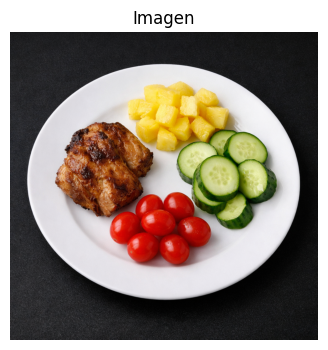

In [96]:
paths = sorted(glob.glob(DATA_DIR + "/*"))
print("Imágenes:", len(paths))

idx = 2 #numero deimagen
img = cv2.imread(paths[idx])

if img is None:
    raise ValueError("No se pudo leer la imagen. Revisa la ruta en 'paths[idx]'.")

show(img, "Imagen")

###  Detección del plato

In [97]:
def detect_plate_mask_solid(bgr):
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)

    # Blanco plato
    plate = cv2.inRange(hsv, (0, 0, 160), (179, 70, 255))

    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (21,21))
    plate = cv2.morphologyEx(plate, cv2.MORPH_CLOSE, k, iterations=2)

    #Componente más grande
    n, labels, stats, _ = cv2.connectedComponentsWithStats(plate, 8)
    if n <= 1:
        plate_big = plate
    else:
        idx_big = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
        plate_big = (labels == idx_big).astype(np.uint8) * 255

    cnts, _ = cv2.findContours(plate_big, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        return plate_big

    cnt = max(cnts, key=cv2.contourArea)
    solid = np.zeros_like(plate_big)
    cv2.drawContours(solid, [cnt], -1, 255, thickness=-1)  # rellena todo el plato

    return solid

### Analizamos el interior de plato 

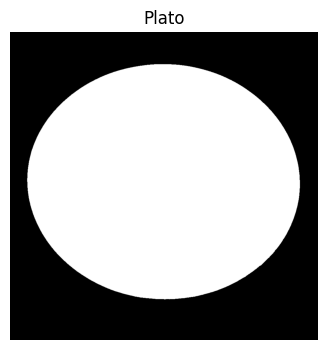

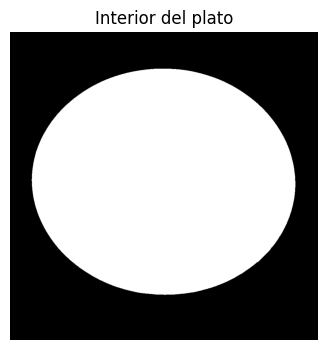

In [98]:
plate_mask = detect_plate_mask_solid(img)
show(plate_mask, "Plato", cmap="gray")

k_in = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (31,31))
plate_in = cv2.erode(plate_mask, k_in, iterations=1)

show(plate_in, "Interior del plato", cmap="gray")

### Segmentación de alimentos 

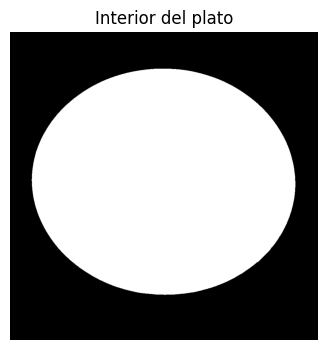

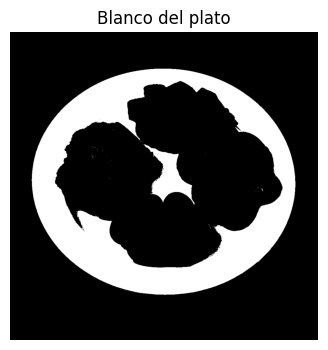

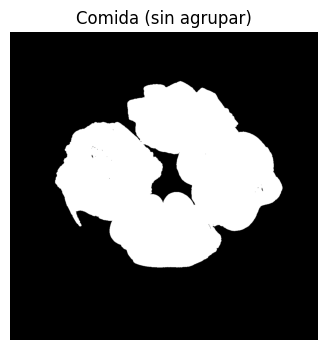

In [99]:
#Interior del plato
k_in = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (31,31))
plate_in = cv2.erode(plate_mask, k_in, iterations=1)
show(plate_in, "Interior del plato", cmap="gray")

# Blanco real del plato
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

white_plate = cv2.inRange(hsv, (0, 0, 200), (179, 40, 255))
white_plate = cv2.bitwise_and(white_plate, plate_in)


if cv2.countNonZero(white_plate) < 8000:
    white_plate = cv2.inRange(hsv, (0, 0, 185), (179, 55, 255))
    white_plate = cv2.bitwise_and(white_plate, plate_in)

show(white_plate, "Blanco del plato", cmap="gray")

#Comida
food_mask = cv2.bitwise_and(cv2.bitwise_not(white_plate), plate_in)

#Pulimos el area 
k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))
food_mask = cv2.morphologyEx(food_mask, cv2.MORPH_OPEN, k, iterations=1)

show(food_mask, "Comida (sin agrupar)", cmap="gray")

### Separación de ROIs

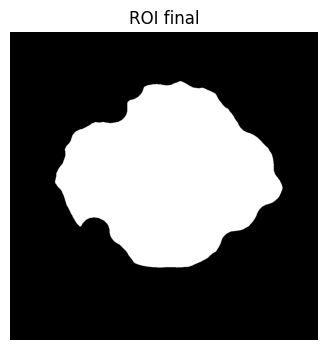

In [100]:

k_merge = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (45,45))
food_merged = cv2.morphologyEx(food_mask, cv2.MORPH_CLOSE, k_merge, iterations=2)

#Relleno de huecos
food_merged = cv2.morphologyEx(food_merged, cv2.MORPH_CLOSE, k_merge, iterations=1)

show(food_merged, "ROI final", cmap="gray")

### Extraemos ROIs

In [105]:
cnts, _ = cv2.findContours(food_merged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

cnt = max(cnts, key=cv2.contourArea)

M = cv2.moments(cnt)
cx = int(M["m10"] / M["m00"])
cy = int(M["m01"] / M["m00"])

print("Centroide ROI:", (cx, cy))

Centroide ROI: (527, 478)


### Ejecutamos el codigo 

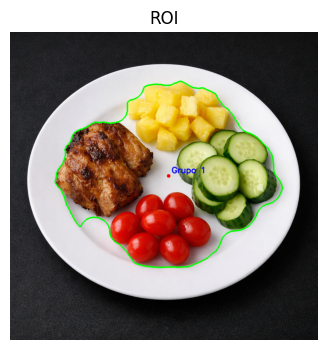

In [104]:
out = img.copy()

cv2.drawContours(out, [cnt], -1, (0,255,0), 3)
cv2.circle(out, (cx,cy), 6, (0,0,255), -1)
cv2.putText(out, "Grupo 1", (cx+10, cy-10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,0,0), 2, cv2.LINE_AA)

show(out, "ROI")